In [1]:
# Convert a Classical Neuron to a Finite Gaussian Neuron and back

In [2]:
from __future__ import print_function
import numpy as np

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# random seeds
torch.manual_seed(665)
np.random.seed(3326)

torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(999)

In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True


In [7]:
### PART 1
# math and visual proof 

# scale of the heat maps
X1 = np.arange(-8,8.1, 0.1)
X2 = np.arange(-8,8.1, 0.1)
X1s, X2s = np.meshgrid(X1,X2)
inputs_heatmap = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
print("shape of heatmap", np.shape(inputs_heatmap))
# print(inputs_heatmap)

shape of heatmap (25921, 2)


In [8]:
num_dim = 2

# classical neuron params
W = np.array([7.0, -1.0])
b = -7.0

# WX+b = 0 line
zero_line = -(W[0]*X1+b)/W[1]

# orthogonal line
ortho_line = W[1]*X1 / W[0]

# point closest to origin will be new centers
centers = (-b/np.dot(W,W))*W
print(centers)

# sig equal to input dim
sig = num_dim

# backwards 
b = -np.dot(W,centers)
print("b=", b)

[ 0.98 -0.14]
b= -7.0


In [9]:
# heatmap neuronal activity
n_activity = np.sum(W*inputs_heatmap, axis=1)+b
print(n_activity.shape)

# heatmap radial activity 
r_activity = np.exp((-1.0/sig**2) *  np.sum(np.square(inputs_heatmap-centers), axis=1))
print(r_activity.shape)

# overall heatmap activity
activity = n_activity*r_activity

(25921,)
(25921,)


<IPython.core.display.Javascript object>


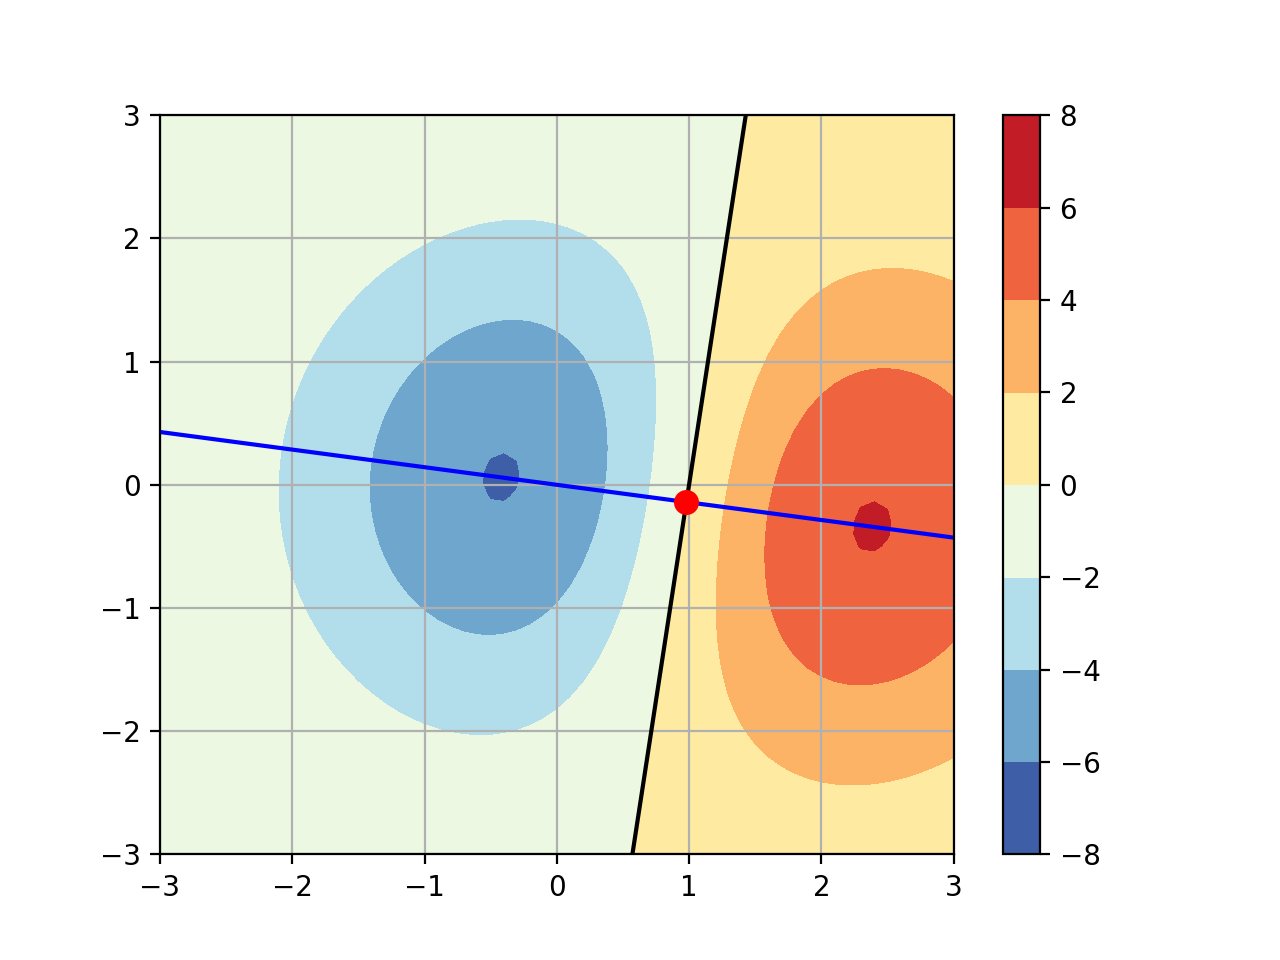

In [10]:
# plot the zero line
plt.plot(X1,zero_line, color='black')
plt.plot(X1,ortho_line, color='blue')
plt.plot(centers[0], centers[1], marker='o', markersize=8, color="red")

# levels = 2*np.arange(-sig,sig+0.1,sig/10.0)
# ticks = 2*np.arange(-sig,sig+1, sig/5.0)

# plt.contourf(X1s, X2s, np.reshape(activity, np.shape(X1s) ), levels=levels, cmap=cm.RdYlBu_r)
plt.contourf(X1s, X2s, np.reshape(activity, np.shape(X1s) ), cmap=cm.RdYlBu_r)

# plt.colorbar(ticks=ticks)
plt.colorbar()
#reset axes
plt.axis([-3,3, -3, 3])
plt.grid(True)
plt.show()

In [11]:
### Part 2 - test conversion

In [12]:
# data to test on: MNIST
batch_size = 2048
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size)

In [13]:
# Initialize the classic network
hidden_layer_sizes = [5]
drop_p= 0.2
classic_model = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p).to(device)

In [14]:
classic_model.state_dict().keys()

['hidden_layers.1.weight',
 'hidden_layers.1.bias',
 'hidden_layers.2.weight',
 'hidden_layers.2.bias',
 'hidden_layers.2.running_mean',
 'hidden_layers.2.running_var',
 'hidden_layers.2.num_batches_tracked',
 'ib.weight',
 'ib.bias',
 'ib.running_mean',
 'ib.running_var',
 'ib.num_batches_tracked',
 'fl.weight',
 'fl.bias']

In [15]:
print("hidden layers:", hidden_layer_sizes)
print("drop prob:", drop_p)
# fgn specific params
covar_type = 'sphere'
print("covariance:", covar_type)
ordinal = float(2)
print("ordinal: {0:.10f}".format(ordinal))
non_lin = False
print("non linearity", non_lin)
noisy_centers = False
print("noisy centers:", noisy_centers)
random_eval = False
print("Random Eval", random_eval)

hidden layers: [5]
drop prob: 0.2
covariance: sphere
ordinal: 2.0000000000
non linearity False
noisy centers: False
Random Eval False


In [16]:
# fgn model init
fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, 
                                     noisy_centers=noisy_centers)

In [17]:
fgn_model.state_dict().keys()

['hidden_layers.1.weights',
 'hidden_layers.1.biases',
 'hidden_layers.1.centers',
 'hidden_layers.1.inv_covars',
 'hidden_layers.2.weight',
 'hidden_layers.2.bias',
 'hidden_layers.2.running_mean',
 'hidden_layers.2.running_var',
 'hidden_layers.2.num_batches_tracked',
 'ib.weight',
 'ib.bias',
 'ib.running_mean',
 'ib.running_var',
 'ib.num_batches_tracked',
 'fl.weights',
 'fl.biases',
 'fl.centers',
 'fl.inv_covars']

In [18]:
# loss func same for both
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

In [19]:
# quick train
classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()),momentum=0.5)
classic_train_res = fgnh.train(classic_model, mnist_train_loader, 
                             cross_ent_loss, classic_optimizer, epochs=1, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

Epoch 0 Train set - Average loss: 1.3823, Accuracy: 25731/50000 (51%)
Test set - Average loss: 0.8126, Accuracy: 7345/10000 (73%)


In [20]:
# perf before conversion:

classic_test_res = fgnh.test(classic_model, mnist_train_loader, cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

classic_test_res = fgnh.test(classic_model, mnist_val_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, mnist_train_loader, cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, mnist_val_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.8420, Accuracy: 36028/50000 (72%)
Test set - Average loss: 0.8126, Accuracy: 7345/10000 (73%)
Test set - Average loss: 2.3079, Accuracy: 4976/50000 (10%)
Test set - Average loss: 2.3080, Accuracy: 955/10000 (10%)


In [21]:
### dev code

In [22]:
from collections import OrderedDict 
import torch
import numpy as np

In [23]:
def convert_state_dict_lin2FGN(lin_state_dict, covar_type, path):
    # given the state dict of a nn.Linear layer,
    # returns a state dict for FGNlayer
    
    fgn_state_dict = OrderedDict()
    
    weights = lin_state_dict.values()[0]
    bias = lin_state_dict.values()[1]
    
    new_centers =  torch.Tensor([(-b/np.dot(x,x))*x for x,b in zip(weights.cpu().detach().numpy(), bias.cpu().detach().numpy())]) 
    
    fgn_state_dict[path+'.'+'weights'] = weights
    fgn_state_dict[path+'.'+'centers'] = new_centers
    fgn_state_dict[path+'.'+'biases'] = bias
    # the number of neurons
    out_features = weights.shape[0]
    in_features = weights.shape[1]
    # default inv_covar (usually small for large neuron radius of activity)
    default_sigma = 25.0*out_features # the number of neurons
    default_inv_covar = 1.0/default_sigma
    if covar_type == 'sphere':
        fgn_state_dict[path+'.inv_covars'] = torch.Tensor(out_features,).fill_(default_inv_covar)
    if covar_type == 'diag':
        fgn_state_dict[path+'.inv_covars'] = torch.Tensor(out_features, in_features).fill_(default_inv_covar)
    if covar_type == 'full':
        fgn_state_dict[path+'.inv_covars'] =  default_inv_covar*torch.eye(in_features, in_features,).expand(out_features,in_features, in_features)
        
    return fgn_state_dict

In [24]:
def build_ordered_dict_for_fgn(classic_model, covar_type, new_state_dict=OrderedDict(), path=''):
    
    ###
    # classic_model: a pytorch module (with a statedict) to be used as base
    # new_state_dict: OrderedDict, will be return. Passed as variable to recursive accumulator
    # path1: used by the recursion, added to the name of the parameter
    ###
    
    # for each module in the classic model
    for (name, param) in classic_model.named_children():
        
        if path != '':
            cur_path = path+'.'+name
        else:
            cur_path = name
            
        # if it's a moduleList, recurse
        if isinstance(param, torch.nn.modules.container.ModuleList):
            new_state_dict = build_ordered_dict_for_fgn(param, covar_type, new_state_dict, path=cur_path)
        # if it's a linear layer, convert
        elif isinstance(param, torch.nn.modules.linear.Linear):
            converted = convert_state_dict_lin2FGN(param.state_dict(), covar_type=covar_type, path=cur_path)
            new_state_dict.update(converted)
        # if it's neither, just put it in the state dict (batchnorm for ex)
        else:
            for key in param.state_dict():
                new_state_dict.update({cur_path+'.'+key:param.state_dict()[key]})
    
    return new_state_dict

In [25]:
def convert_classic_to_fgn(classic_model, fgn_model):
    # given two similar models, one Feedforward_Classic_net, one Feedforward_FGN_net
    # built with the same hidden_l_nums, drop_p
    
    # get covar_type
    covar_type = fgn_model.fl.covar_type
    
    # create the state dict to be loaded
    new_state_dict = build_ordered_dict_for_fgn(classic_model, covar_type)
    
    fgn_model.load_state_dict(new_state_dict)
    
    #return nothing

In [26]:
convert_classic_to_fgn(classic_model, fgn_model)

In [27]:
# perf after conversion:

classic_test_res = fgnh.test(classic_model, mnist_train_loader, cross_ent_loss,
                             pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

classic_test_res = fgnh.test(classic_model, mnist_val_loader, cross_ent_loss, 
                             pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, mnist_train_loader, cross_ent_loss,
                         pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, mnist_val_loader, cross_ent_loss,
                         pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.8420, Accuracy: 36028/50000 (72%)
Test set - Average loss: 0.8126, Accuracy: 7345/10000 (73%)
Test set - Average loss: 2.7421, Accuracy: 36949/50000 (74%)
Test set - Average loss: 2.4641, Accuracy: 7466/10000 (75%)


In [28]:
def convert_state_dict_FGN2lin(fgn_state_dict, covar_type, path):
    # given the state dict of a nn.Linear layer,
    # returns a state dict for FGNlayer
        
    lin_state_dict = OrderedDict()
    
    weights = fgn_state_dict.values()[0]
    biases = fgn_state_dict.values()[1]
    centers = fgn_state_dict.values()[2]
#     biases = torch.Tensor([-np.dot(w,c) for w,c in zip(weights.cpu().detach().numpy(),
#                                                          centers.cpu().detach().numpy())])

    lin_state_dict[path+'.'+'weight'] = weights
    lin_state_dict[path+'.'+'bias'] = biases
    
    return lin_state_dict

In [29]:
def build_ordered_dict_for_classic(fgn_model, new_state_dict=OrderedDict(), path=''):
    
    ###
    # fgn_model: a pytorch module (with a statedict) to be used as base
    # new_state_dict: OrderedDict, will be return. Passed as variable to recursive accumulator
    # path1: used by the recursion, added to the name of the parameter
    ###
    
    # for each module in the classic model
    for (name, param) in fgn_model.named_children():
        
        if path != '':
            cur_path = path+'.'+name
        else:
            cur_path = name
            
        # if it's a moduleList, recurse
        if isinstance(param, torch.nn.modules.container.ModuleList):
            new_state_dict = build_ordered_dict_for_classic(param, new_state_dict, path=cur_path)
        # if it's a FGN_layer, convert
        elif isinstance(param, fgnl.FGN_layer):
            converted = convert_state_dict_FGN2lin(param.state_dict(), covar_type=covar_type, path=cur_path)
            new_state_dict.update(converted)
        # if it's neither, just put it in the state dict (batchnorm for ex)
        else:
            for key in param.state_dict():
                new_state_dict.update({cur_path+'.'+key:param.state_dict()[key]})
    
    return new_state_dict

In [30]:
def convert_fgn_to_classic(fgn_model, classic_model):
    # given two similar models, one Feedforward_Classic_net, one Feedforward_FGN_net
    # built with the same hidden_l_nums, drop_p
    
    # create the state dict to be loaded
    new_state_dict = build_ordered_dict_for_classic(fgn_model)
    
    classic_model.load_state_dict(new_state_dict)
    
    #return nothing

In [31]:
convert_fgn_to_classic(fgn_model, classic_model)

In [32]:
# perf after conversion:

classic_test_res = fgnh.test(classic_model, mnist_train_loader, cross_ent_loss,
                             pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

classic_test_res = fgnh.test(classic_model, mnist_val_loader, cross_ent_loss, 
                             pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, mnist_train_loader, cross_ent_loss,
                         pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, mnist_val_loader, cross_ent_loss,
                         pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.8420, Accuracy: 36028/50000 (72%)
Test set - Average loss: 0.8126, Accuracy: 7345/10000 (73%)
Test set - Average loss: 2.7421, Accuracy: 36949/50000 (74%)
Test set - Average loss: 2.4641, Accuracy: 7466/10000 (75%)
